# Copenhagen

In [459]:
import pandas as pd
import numpy as np
import seaborn as sns 
from feature_engine.imputation import RandomSampleImputer
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

df = pd.read_csv('../data/raw/listings.csv')
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,26057,Home in Copenhagen · ★4.91 · 4 bedrooms · 4 be...,109777,Kari,NaN,Indre By,55.69307,12.57649,Entire home/apt,2900.0,5,57,2022-08-09,0.46,1,356,0,NaN
1,26473,Townhouse in Copenhagen · ★4.55 · 6 bedrooms ·...,112210,Julia,NaN,Indre By,55.67602,12.57540,Entire home/apt,3350.0,3,341,2023-12-04,2.12,1,74,37,NaN


## Missing Data

<Axes: >

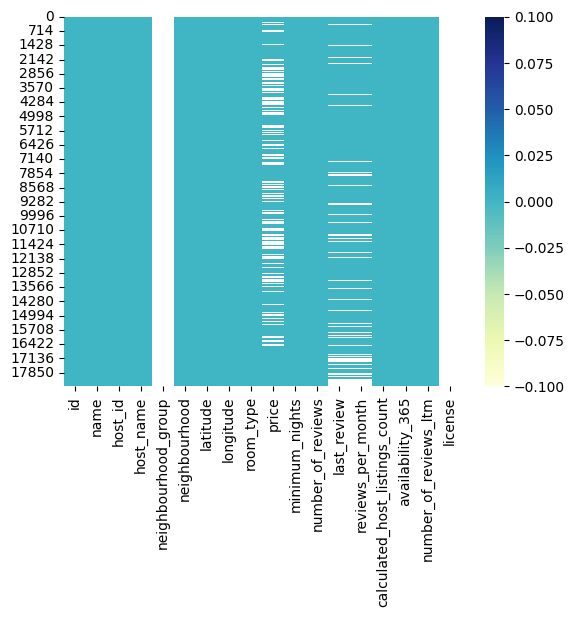

In [460]:
sns.heatmap(df.isna(), cmap="YlGnBu", mask=df.isna())

Dropping neighbourhood group, since all values are NaN.

In [461]:
# Dropping neighbourhood group
df = df.drop(columns='neighbourhood_group')

Dropping license, since all values are NaN.

In [462]:
df = df.drop(columns='license')

Dropping last review, since it won’t be all that useful in the clustering.

In [463]:
df = df.drop(columns='last_review')

Dropping host name, since different hosts may have the same name, and it’s more useful to use host id

In [464]:
df = df.drop(columns=['host_name'])

Treating NaN values - Price

In [465]:
df['price'].kurt()

1748.4941199990024

In [466]:
# Replacing the NaNs randomly
imp_random = RandomSampleImputer(['price']) 
df = imp_random.fit_transform(df)

Treating NaN values - Reviews per Month

In [467]:
df['reviews_per_month'].kurt()

167.5801491631379

In [468]:
# Replacing the NaNs randomly
imp_random = RandomSampleImputer(['reviews_per_month']) 
df = imp_random.fit_transform(df)

Checking there are no more NaNs.

<Axes: >

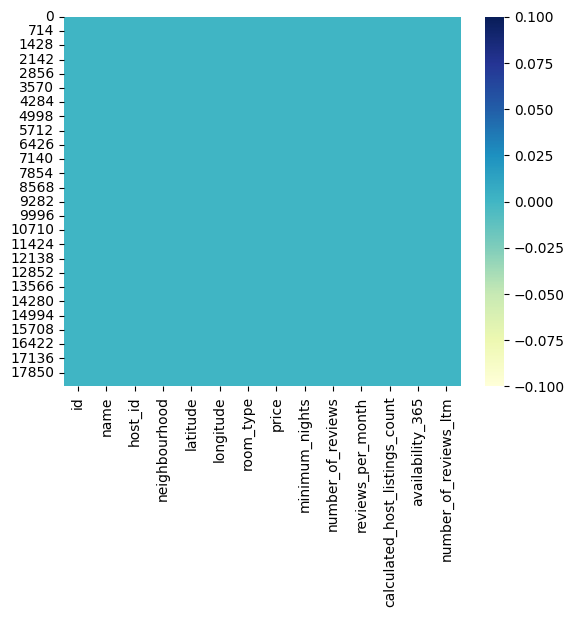

In [469]:
sns.heatmap(df.isna(), cmap="YlGnBu", mask=df.isna())

## Splitting the name column

In [470]:
def extract_info(row):
    name = row['name']
    parts = name.split(' · ')
    rating = None
    property = None
    location = None
    
    # Extracting rating
    if len(parts) > 1:
        rating_text = parts[1]
        if '★' in rating_text:
            rating = rating_text.replace('★', '')

    # Extracting property and location
    if len(parts) > 0:
        property_location = parts[0].split(' in ')
        if len(property_location) == 2:
            property = property_location[0].replace(',', '')
            location = property_location[1]

    # Extracting the number of bedrooms, beds, and bathrooms 
    bedrooms = None
    beds = None
    bathrooms = None
    if len(parts) > 2:
        for part in parts[2:]:
            if 'bedroom' in part:
                bedrooms = part.split(' ')[0]
            elif 'bed' in part:
                beds = part.split(' ')[0]
            elif 'bath' in part:
                bathrooms = part.split(' ')[0]

    return pd.Series([rating, bedrooms, beds, bathrooms, property, location])

# Creating new columns utilizing the function extract_info
df[['rating', 'bedrooms', 'beds', 'bathrooms', 'property', 'location']] = df.apply(extract_info, axis=1)

# Deleting the original name column 
df.drop(columns=['name'], inplace=True)
df.head(3)

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,rating,bedrooms,beds,bathrooms,property,location
0,26057,109777,Indre By,55.69307,12.57649,Entire home/apt,2900.0,5,57,0.46,1,356,0,4.91,4,4,1.5,Home,Copenhagen
1,26473,112210,Indre By,55.67602,12.57540,Entire home/apt,3350.0,3,341,2.12,1,74,37,4.55,6,5,2,Townhouse,Copenhagen
2,29118,125230,Vesterbro-Kongens Enghave,55.67023,12.55504,Entire home/apt,1000.0,7,26,0.16,1,0,1,4.85,1,1,1,Rental unit,Copenhagen


In [471]:
# Replacing the abnormal values in the name columns
df['bathrooms'] = df['bathrooms'].replace({'Half-bath':'0.5', 'Shared':'1'}).astype(float)
df['rating'] = df['rating'].replace({'New':'0'}).astype(float)

# Changing the data types
df['beds'] = df['beds'].astype(float)
df['bedrooms'] = df['bedrooms'].astype(float)

In [472]:
# Filling the NaN values
imp_random = RandomSampleImputer(['rating']) 
df = imp_random.fit_transform(df)

imp_random = RandomSampleImputer(['bedrooms']) 
df = imp_random.fit_transform(df)

imp_random = RandomSampleImputer(['beds']) 
df = imp_random.fit_transform(df)

imp_random = RandomSampleImputer(['bathrooms']) 
df = imp_random.fit_transform(df)

In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18545 entries, 0 to 18544
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              18545 non-null  int64  
 1   host_id                         18545 non-null  int64  
 2   neighbourhood                   18545 non-null  object 
 3   latitude                        18545 non-null  float64
 4   longitude                       18545 non-null  float64
 5   room_type                       18545 non-null  object 
 6   price                           18545 non-null  float64
 7   minimum_nights                  18545 non-null  int64  
 8   number_of_reviews               18545 non-null  int64  
 9   reviews_per_month               18545 non-null  float64
 10  calculated_host_listings_count  18545 non-null  int64  
 11  availability_365                18545 non-null  int64  
 12  number_of_reviews_ltm           

There are no more NaN values :)

## Scaling and encoding the data

In [474]:
encoder = OrdinalEncoder()

a = np.array(df['neighbourhood']).reshape(-1,1)
df['neighbourhood_encoded'] = encoder.fit_transform(a) 

a = np.array(df['room_type']).reshape(-1,1)
df['room_type_encoded'] = encoder.fit_transform(a) 

a = np.array(df['property']).reshape(-1,1)
df['property_encoded'] = encoder.fit_transform(a) 

a = np.array(df['location']).reshape(-1,1)
df['location_encoded'] = encoder.fit_transform(a) 

df.head(2)

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,...,rating,bedrooms,beds,bathrooms,property,location,neighbourhood_encoded,room_type_encoded,property_encoded,location_encoded
0,26057,109777,Indre By,55.69307,12.57649,Entire home/apt,2900.0,5,57,0.46,...,4.91,4.0,4.0,1.5,Home,Copenhagen,1,1,1,1
1,26473,112210,Indre By,55.67602,12.57540,Entire home/apt,3350.0,3,341,2.12,...,4.55,6.0,5.0,2.0,Townhouse,Copenhagen,1,1,2,1


In [475]:
# Creating a df with only numeric values
df_encoded = df.copy()
df_encoded = df_encoded.drop(columns='neighbourhood')
df_encoded = df_encoded.drop(columns='room_type')
df_encoded = df_encoded.drop(columns='property')
df_encoded = df_encoded.drop(columns='location')
df_encoded = df_encoded.drop(columns='id')
df_encoded.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,rating,bedrooms,beds,bathrooms,neighbourhood_encoded,room_type_encoded,property_encoded,location_encoded
0,109777,55.693070,12.576490,2900.0,5,57,0.46,1,356,0,4.91,4.0,4.0,1.5,1,1,1,1
1,112210,55.676020,12.575400,3350.0,3,341,2.12,1,74,37,4.55,6.0,5.0,2.0,1,1,2,1
2,125230,55.670230,12.555040,1000.0,7,26,0.16,1,0,1,4.85,1.0,1.0,1.0,2,1,3,1
3,1634152,55.692680,12.554860,1500.0,3,63,0.63,1,0,0,4.86,1.0,1.0,1.0,3,2,3,1
4,129976,55.666602,12.555283,450.0,3,19,0.12,1,0,0,4.88,4.0,2.0,1.5,2,1,4,1


In [476]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_encoded)
df_scaled = pd.DataFrame(df_scaled, columns=df_encoded.columns)
df_scaled.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,rating,bedrooms,beds,bathrooms,neighbourhood_encoded,room_type_encoded,property_encoded,location_encoded
0,0.000198,0.662035,0.659541,0.027785,0.003568,0.037231,0.011889,0.0,0.975342,0.000000,0.982,0.214286,0.230769,0.3,0.0,0.000000,0.000000,0.0
1,0.000202,0.515783,0.653672,0.032290,0.001784,0.222730,0.055746,0.0,0.202740,0.048240,0.910,0.357143,0.307692,0.4,0.0,0.000000,0.033333,0.0
2,0.000226,0.466118,0.544045,0.008761,0.005352,0.016982,0.003963,0.0,0.000000,0.001304,0.970,0.000000,0.000000,0.2,0.1,0.000000,0.066667,0.0
3,0.002956,0.658689,0.543076,0.013767,0.001784,0.041150,0.016380,0.0,0.000000,0.000000,0.972,0.000000,0.000000,0.2,0.2,0.333333,0.066667,0.0
4,0.000234,0.434995,0.545354,0.003254,0.001784,0.012410,0.002906,0.0,0.000000,0.000000,0.976,0.214286,0.076923,0.3,0.1,0.000000,0.100000,0.0


## KMeans

In [477]:
k=5

# Initializing the model
kmeans = KMeans(n_clusters=k, random_state=69)
# Training the model
kmeans.fit(df_scaled)
# Labeling the clusters
cluster_labels = kmeans.labels_
df_scaled['cluster_kmeans'] = cluster_labels

## KMeans++

In [478]:
# Initializing the model
kmeans_plus = KMeans(init='k-means++', random_state=69)
# Training the model
kmeans_plus.fit(df_scaled)
# Labeling the clusters
cluster_labels = kmeans_plus.labels_
df_scaled['cluster_kmeans_plus'] = cluster_labels

## DBSCAN

In [479]:
from sklearn.cluster import DBSCAN

# Initializing DBSCAN
dbscan = DBSCAN()

# Training the model
dbscan.fit(df_scaled)

# Labeling the clusters
cluster_labels = dbscan.labels_
df_scaled['cluster_dbscan'] = cluster_labels

# Final Clusters

In [480]:
df_scaled.head(8)

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,...,bedrooms,beds,bathrooms,neighbourhood_encoded,room_type_encoded,property_encoded,location_encoded,cluster_kmeans,cluster_kmeans_plus,cluster_dbscan
0,0.000198,0.662035,0.659541,0.027785,0.003568,0.037231,0.011889,0.000000,0.975342,0.000000,...,0.214286,0.230769,0.3,0.0,0.000000,0.000000,0.0,1,4,0
1,0.000202,0.515783,0.653672,0.032290,0.001784,0.222730,0.055746,0.000000,0.202740,0.048240,...,0.357143,0.307692,0.4,0.0,0.000000,0.033333,0.0,0,6,1
2,0.000226,0.466118,0.544045,0.008761,0.005352,0.016982,0.003963,0.000000,0.000000,0.001304,...,0.000000,0.000000,0.2,0.1,0.000000,0.066667,0.0,0,0,2
3,0.002956,0.658689,0.543076,0.013767,0.001784,0.041150,0.016380,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.2,0.2,0.333333,0.066667,0.0,0,0,2
4,0.000234,0.434995,0.545354,0.003254,0.001784,0.012410,0.002906,0.000000,0.000000,0.000000,...,0.214286,0.076923,0.3,0.1,0.000000,0.100000,0.0,0,0,2
5,0.002543,0.610396,0.558960,0.008681,0.000000,0.004572,0.001585,0.000000,0.791781,0.001304,...,0.000000,0.000000,0.2,0.2,0.000000,0.100000,0.0,1,4,0
6,0.000253,0.486773,0.530331,0.012766,0.001784,0.052907,0.012946,0.005405,0.000000,0.005215,...,0.071429,0.153846,0.4,0.1,0.000000,0.066667,0.0,0,0,2
7,0.003003,0.637931,0.567844,0.007259,0.003568,0.007185,0.003435,0.000000,0.000000,0.001304,...,0.142857,0.307692,0.2,0.2,0.000000,0.066667,0.0,0,0,2
